In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import torchvision.models as models
from tqdm import tqdm
import timm
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:


# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

print("class_to_idx:", train_dataset.class_to_idx)

import torch
from torch import nn, optim
from transformers import DeiTForImageClassification, AutoImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224", weights_only=True)
model = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224", weights_only=False
)
model.to(device)

class_to_idx: {'Negative': 0, 'Positive': 1}


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [22]:
for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 1).to(device)

model.classifier.requires_grad_(True)
# 4) Optimizer only over heads
optimizer = optim.Adam(
    list(model.classifier.parameters()),
    lr=1e-3
)

# 5) BCE on logits (no sigmoid inside the loss)
criterion = nn.BCEWithLogitsLoss()


In [25]:
def train_one_epoch():
    model.train()
    total_loss = 0.0

    for imgs, labels in tqdm(train_loader, desc="Training", leave=False):
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (N,1)

        out = model(pixel_values=imgs)
        logits = out.logits

        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        out = model(pixel_values=imgs)
        logits = out.logits

        loss = criterion(logits, labels)
        total_loss += loss.item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        correct += (preds.cpu() == labels.cpu().long().squeeze(1)).sum().item()
        total += labels.size(0)

    acc = correct / total
    avg_loss = total_loss / total
    return acc, avg_loss


In [26]:
epochs = 10
for epoch in range(epochs):
    train_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | Acc: {acc:.3f}")


Epoch 1/10 | Train loss: 0.5539 | Val loss: 0.4650 | Acc: 0.770


Epoch 2/10 | Train loss: 0.4341 | Val loss: 0.4064 | Acc: 0.806


Epoch 3/10 | Train loss: 0.3843 | Val loss: 0.3744 | Acc: 0.802


Epoch 4/10 | Train loss: 0.3553 | Val loss: 0.3581 | Acc: 0.834


Epoch 5/10 | Train loss: 0.3344 | Val loss: 0.3449 | Acc: 0.839


Epoch 6/10 | Train loss: 0.3196 | Val loss: 0.3341 | Acc: 0.848


Epoch 7/10 | Train loss: 0.3061 | Val loss: 0.3286 | Acc: 0.857


Epoch 8/10 | Train loss: 0.2975 | Val loss: 0.3187 | Acc: 0.866


Epoch 9/10 | Train loss: 0.2880 | Val loss: 0.3150 | Acc: 0.848


Epoch 10/10 | Train loss: 0.2798 | Val loss: 0.3131 | Acc: 0.853


              precision    recall  f1-score   support

    Negative     0.8743    0.9299    0.9012       157
    Positive     0.7800    0.6500    0.7091        60

    accuracy                         0.8525       217
   macro avg     0.8271    0.7900    0.8052       217
weighted avg     0.8482    0.8525    0.8481       217

Confusion Matrix:
 [[146  11]
 [ 21  39]]


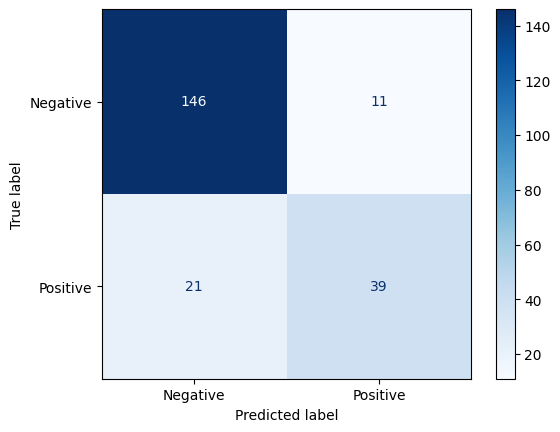

In [28]:

@torch.no_grad()
def evaluate_predictions():
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        out = model(pixel_values=imgs)
        logits = out.logits

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        
    return all_labels, all_preds


# ---- Generate reports ----
labels, preds = evaluate_predictions()

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
